In [0]:
#import findspark
#findspark.init()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import squarify
from sklearn.metrics import roc_curve, auc

#Biblioteca PySpark
import warnings
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count, udf, isnan,avg
from pyspark import SparkFiles

#Bioblioteca ML para PySpark
from pyspark.ml import Pipeline

#Importar el SO
from time import time
from pyspark.conf import SparkConf
import os

In [0]:
urlICFES="https://raw.githubusercontent.com/Kahsma/Proyecto_PDGE/refs/heads/main/Datos/Icfes.csv"
spark.sparkContext.addFile(urlICFES)

In [0]:
dfICFES = spark.read.csv("file://"+SparkFiles.get("Icfes.csv"),header = True, inferSchema = True)

In [0]:
dfICFES.columns

['ESTU_MCPIO_RESIDE',
 'ESTU_COD_RESIDE_MCPIO',
 'PUNT_LECTURA_CRITICA',
 'PERCENTIL_LECTURA_CRITICA',
 'DESEMP_LECTURA_CRITICA',
 'PUNT_MATEMATICAS',
 'PERCENTIL_MATEMATICAS',
 'DESEMP_MATEMATICAS',
 'PUNT_C_NATURALES',
 'PERCENTIL_C_NATURALES',
 'PUNT_SOCIALES_CIUDADANAS',
 'PERCENTIL_SOCIALES_CIUDADANAS',
 'DESEMP_SOCIALES_CIUDADANAS',
 'PUNT_INGLES',
 'PUNT_GLOBAL',
 'PERCENTIL_GLOBAL',
 'ESTU_COD_RESIDE_DEPTO',
 'ESTU_DEPTO_RESIDE',
 'PERCENTIL_INGLES',
 'DESEMP_C_NATURALES',
 'DESEMP_INGLES']

In [0]:
dfICFES.printSchema()

root
 |-- ESTU_MCPIO_RESIDE: string (nullable = true)
 |-- ESTU_COD_RESIDE_MCPIO: integer (nullable = true)
 |-- PUNT_LECTURA_CRITICA: integer (nullable = true)
 |-- PERCENTIL_LECTURA_CRITICA: integer (nullable = true)
 |-- DESEMP_LECTURA_CRITICA: integer (nullable = true)
 |-- PUNT_MATEMATICAS: integer (nullable = true)
 |-- PERCENTIL_MATEMATICAS: integer (nullable = true)
 |-- DESEMP_MATEMATICAS: integer (nullable = true)
 |-- PUNT_C_NATURALES: integer (nullable = true)
 |-- PERCENTIL_C_NATURALES: integer (nullable = true)
 |-- PUNT_SOCIALES_CIUDADANAS: integer (nullable = true)
 |-- PERCENTIL_SOCIALES_CIUDADANAS: integer (nullable = true)
 |-- DESEMP_SOCIALES_CIUDADANAS: integer (nullable = true)
 |-- PUNT_INGLES: integer (nullable = true)
 |-- PUNT_GLOBAL: integer (nullable = true)
 |-- PERCENTIL_GLOBAL: integer (nullable = true)
 |-- ESTU_COD_RESIDE_DEPTO: integer (nullable = true)
 |-- ESTU_DEPTO_RESIDE: string (nullable = true)
 |-- PERCENTIL_INGLES: integer (nullable = true)
 |

In [0]:
display(dfICFES)

+-----------------+---------------------+--------------------+-------------------------+----------------------+----------------+---------------------+------------------+----------------+---------------------+------------------------+-----------------------------+--------------------------+-----------+-----------+----------------+---------------------+-----------------+----------------+------------------+-------------+
|ESTU_MCPIO_RESIDE|ESTU_COD_RESIDE_MCPIO|PUNT_LECTURA_CRITICA|PERCENTIL_LECTURA_CRITICA|DESEMP_LECTURA_CRITICA|PUNT_MATEMATICAS|PERCENTIL_MATEMATICAS|DESEMP_MATEMATICAS|PUNT_C_NATURALES|PERCENTIL_C_NATURALES|PUNT_SOCIALES_CIUDADANAS|PERCENTIL_SOCIALES_CIUDADANAS|DESEMP_SOCIALES_CIUDADANAS|PUNT_INGLES|PUNT_GLOBAL|PERCENTIL_GLOBAL|ESTU_COD_RESIDE_DEPTO|ESTU_DEPTO_RESIDE|PERCENTIL_INGLES|DESEMP_C_NATURALES|DESEMP_INGLES|
+-----------------+---------------------+--------------------+-------------------------+----------------------+----------------+---------------------+------

In [0]:
# Para encontrar los valores nulos 
# Calculate the count of nulls or NaNs for each column
null_counts = dfICFES.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfICFES.columns
])

# Filter to show only columns with non-zero counts of nulls or NaNs
filtered_null_counts = null_counts.select([
    col(c) for c in null_counts.columns if null_counts.select(c).first()[0] > 0
])

filtered_null_counts.show()

+-----------------+---------------------+-----------+---------------------+-----------------+
|ESTU_MCPIO_RESIDE|ESTU_COD_RESIDE_MCPIO|PUNT_INGLES|ESTU_COD_RESIDE_DEPTO|ESTU_DEPTO_RESIDE|
+-----------------+---------------------+-----------+---------------------+-----------------+
|                2|                    2|        334|                    2|                2|
+-----------------+---------------------+-----------+---------------------+-----------------+



In [0]:
# Filter out rows where either 'ESTU_DEPTO_RESIDE' or 'ESTU_MCPIO_RESIDE' is null or empty
df_filtered = dfICFES.filter(
    (col("ESTU_DEPTO_RESIDE").isNotNull()) & (col("ESTU_DEPTO_RESIDE") != "") & 
    (col("ESTU_MCPIO_RESIDE").isNotNull()) & (col("ESTU_MCPIO_RESIDE") != "")
)

null_counts = df_filtered.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_filtered.columns
])

# Filter to show only columns with non-zero counts of nulls or NaNs
filtered_null_counts = null_counts.select([
    col(c) for c in null_counts.columns if null_counts.select(c).first()[0] > 0
])

filtered_null_counts.show()

+-----------+
|PUNT_INGLES|
+-----------+
|        334|
+-----------+



In [0]:
# Calculate the average value of the 'PUNT_INGLES' column
average_punt_ingles = df_filtered.select(avg(col("PUNT_INGLES"))).first()[0]

# Replace null or empty values in 'PUNT_INGLES' with the average
df_filled = df_filtered.withColumn(
    "PUNT_INGLES", 
    when(col("PUNT_INGLES").isNull() | (col("PUNT_INGLES") == ""), average_punt_ingles)
    .otherwise(col("PUNT_INGLES"))
)



In [0]:
null_counts = df_filled.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_filled.columns
])

# Filter to show only columns with non-zero counts of nulls or NaNs
filtered_null_counts = null_counts.select([
    col(c) for c in null_counts.columns if null_counts.select(c).first()[0] > 0
])

##Como ya no retorna nada ya no hay datos invalidos

In [0]:
display(df_filled)

ESTU_MCPIO_RESIDE ESTU_COD_RESIDE_MCPIO PUNT_LECTURA_CRITICA PERCENTIL_LECTURA_CRITICA DESEMP_LECTURA_CRITICA PUNT_MATEMATICAS PERCENTIL_MATEMATICAS DESEMP_MATEMATICAS PUNT_C_NATURALES PERCENTIL_C_NATURALES PUNT_SOCIALES_CIUDADANAS PERCENTIL_SOCIALES_CIUDADANAS DESEMP_SOCIALES_CIUDADANAS PUNT_INGLES PUNT_GLOBAL PERCENTIL_GLOBAL ESTU_COD_RESIDE_DEPTO ESTU_DEPTO_RESIDE PERCENTIL_INGLES DESEMP_C_NATURALES DESEMP_INGLES CAJICÁ 25126 54 57 3 65 89 3 41 29 33 11 1 55.0 244 49 25 CUNDINAMARCA 81 2 A1 CAJICÁ 25126 57 67 3 43 26 2 46 45 49 55 2 33.0 238 44 25 CUNDINAMARCA 6 2 A- CAJICÁ 25126 59 73 3 72 97 4 63 92 68 95 3 59.0 325 94 25 CUNDINAMARCA 87 3 A2 CAJICÁ 25126 47 32 2 55 64 3 46 43 43 38 2 47.0 238 45 25 CUNDINAMARCA 58 2 A- CAJICÁ 25126 37 8 2 48 42 2 44 38 32 7 1 43.0 202 19 25 CUNDINAMARCA 40 2 A- CAJICÁ 25126 58 72 3 45 31 2 38 19 40 27 1 35.0 222 33 25 CUNDINAMARCA 12 1 A- CAJICÁ 25126 49 37 2 68 93 3 50 58 51 59 2 65.0 277 72 25 CUNDINAMARCA 92 2 A2 CAJICÁ 25126 64 89 3 57 70 3 64 93 67 94 3 73.0 319 92 25 CUNDINAMARCA 97 3 B1 TABIO 25785 45 25 2 47 38 2 55 74 52 63 2 49.0 248 52 25 CUNDINAMARCA 66 2 A1 TABIO 25785 43 21 2 45 31 2 44 39 39 25 1 36.0 211 25 25 CUNDINAMARCA 15 2 A- TABIO 25785 55 60 3 58 72 3 52 66 61 84 3 46.0 278 73 25 CUNDINAMARCA 52 2 A- CAJICÁ 25126 64 89 3 70 96 3 58 82 64 90 3 54.0 316 91 25 CUNDINAMARCA 80 3 A1 CAJICÁ 25126 64 89 3 67 92 3 59 84 58 78 3 76.0 315 91 25 CUNDINAMARCA 98 3 B1 CAJICÁ 25126 55 61 3 34 8 1 43 35 50 57 2 45.0 227 37 25 CUNDINAMARCA 51 2 A- CAJICÁ 25126 59 75 3 67 92 3 61 89 59 80 3 53.0 304 87 25 CUNDINAMARCA 78 3 A1 CAJICÁ 25126 54 55 3 53 56 3 34 8 37 20 1 60.0 228 38 25 CUNDINAMARCA 88 1 A2 CAJICÁ 25126 57 66 3 56 66 3 41 28 47 50 2 68.0 258 59 25 CUNDINAMARCA 94 2 B1 CAJICÁ 25126 47 32 2 56 65 3 39 21 46 46 2 39.0 232 40 25 CUNDINAMARCA 25 1 A- CAJICÁ 25126 70 97 4 74 98 4 65 94 70 97 3 78.0 352 98 25 CUNDINAMARCA 99 3 B1 RIONEGRO 5615 66 92 4 53 55 3 53 69 56 73 3 40.0 278 73 5 ANTIOQUIA 29 2 A- CARTAGENA DE INDIAS 13001 43 20 2 43 26 2 48 51 42 34 2 43.0 220 31 13 BOLIVAR 42 2 A- CARTAGENA DE INDIAS 13001 43 19 2 37 12 2 37 15 31 6 1 44.0 188 11 13 BOLIVAR 47 1 A- CARTAGENA DE INDIAS 13001 40 13 2 47 37 2 44 39 35 16 1 44.0 208 23 13 BOLIVAR 44 2 A- RIONEGRO 5615 50 41 2 44 29 2 38 20 37 21 1 35.0 208 23 5 ANTIOQUIA 12 1 A- PAMPLONA 54518 66 92 4 55 65 3 55 74 61 85 3 60.0 297 83 54 NORTE SANTANDER 88 2 A2 FLORENCIA 18001 57 68 3 60 77 3 52 63 56 72 3 38.0 274 70 18 CAQUETA 21 2 A- PEREIRA 66001 52 50 3 56 65 3 49 56 60 83 3 54.0 271 68 66 RISARALDA 80 2 A1 PEREIRA 66001 43 20 2 50 45 2 41 26 39 24 1 34.0 213 26 66 RISARALDA 9 2 A- PEREIRA 66001 60 78 3 58 73 3 58 82 63 89 3 41.0 292 81 66 RISARALDA 35 3 A- BARRANCABERMEJA 68081 39 10 2 39 17 2 33 7 47 48 2 35.0 196 15 68 SANTANDER 10 1 A- BARRANCABERMEJA 68081 45 25 2 52 52 3 42 30 41 31 2 52.0 228 37 68 SANTANDER 74 2 A1 SAN VICENTE DE CHUCURÍ 68689 50 41 2 50 45 2 40 24 44 39 2 43.0 229 38 68 SANTANDER 42 1 A- CARTAGENA DE INDIAS 13001 47 31 2 27 2 1 28 1 32 8 1 39.0 170 3 13 BOLIVAR 26 1 A- MAHATES 13433 38 10 2 20 1 1 27 1 32 8 1 48.0 153 1 13 BOLIVAR 60 1 A1 CARTAGENA DE INDIAS 13001 59 74 3 75 99 4 64 93 72 98 4 48.0 330 95 13 BOLIVAR 61 3 A1 LANDÁZURI 68385 36 6 2 42 24 2 34 8 39 24 1 42.0 190 12 68 SANTANDER 38 1 A- CARTAGENA DE INDIAS 13001 48 36 2 51 49 3 51 60 44 41 2 39.0 239 45 13 BOLIVAR 27 2 A- CARTAGENA DE INDIAS 13001 47 30 2 44 30 2 43 33 40 28 1 57.0 223 33 13 BOLIVAR 85 2 A1 CARTAGENA DE INDIAS 13001 36 7 2 32 6 1 35 10 28 3 1 64.0 176 5 13 BOLIVAR 91 1 A2 URRAO 5847 57 68 3 50 47 2 47 48 55 70 2 42.0 257 59 5 ANTIOQUIA 36 2 A- PUEBLOVIEJO 47570 38 9 2 39 17 2 30 2 31 7 1 37.0 173 5 47 MAGDALENA 18 1 A- CIÉNAGA 47189 35 5 1 31 4 1 36 14 27 2 1 39.0 164 2 47 MAGDALENA 23 1 A- CIÉNAGA 47189 56 64 3 44 29 2 44 39 42 33 2 33.0 227 37 47 MAGDALENA 5 2 A- PUEBLOVIEJO 47570 55 61 3 51 51 3 51 61 54 67 2 46.0 261 62 47 MAGDALENA 55 2 A- CIÉNAGA 47189 37 8 2 51 50 3 50 57 52 61 2 48.0 238 44 47 MAGDALENA 

In [0]:
display(df_filled.describe())

summary ESTU_MCPIO_RESIDE ESTU_COD_RESIDE_MCPIO PUNT_LECTURA_CRITICA PERCENTIL_LECTURA_CRITICA DESEMP_LECTURA_CRITICA PUNT_MATEMATICAS PERCENTIL_MATEMATICAS DESEMP_MATEMATICAS PUNT_C_NATURALES PERCENTIL_C_NATURALES PUNT_SOCIALES_CIUDADANAS PERCENTIL_SOCIALES_CIUDADANAS DESEMP_SOCIALES_CIUDADANAS PUNT_INGLES PUNT_GLOBAL PERCENTIL_GLOBAL ESTU_COD_RESIDE_DEPTO ESTU_DEPTO_RESIDE PERCENTIL_INGLES DESEMP_C_NATURALES DESEMP_INGLES count 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 504870 mean null 32579.04694079664 52.15674332006259 50.19383801770753 2.612848852179769 51.01968229445204 50.229397666726086 2.4708221918513678 48.197316140788715 50.27121437201656 48.233883970130925 50.23796422841524 2.02069245548359 46.88343745540461 248.3468179927506 50.09767464891952 36.09967120248777 null 50.12352486778775 2.012351694495613 null stddev null 26367.519504756016 10.158423464130355 28.9079527296465 0.7258440860298633 11.647621080710579 28.872364512686783 0.721228083520212 10.499592089316593 28.864311089395667 11.97057575317051 28.88932090214801 0.8257683538121229 11.3093375950026 48.69240413533915 28.903833721194218 613.8109911178849 null 28.92788617451759 0.7526996873649763 null min ABEJORRAL 5001 0 1 1 0 1 1 0 1 0 1 1 0.0 0 1 5 AMAZONAS 1 1 A- max ÚTICA 99999 100 100 4 100 100 4 100 100 100 100 4 100.0 500 100 99999 VICHADA 100 4 B1

In [0]:
df_filled.printSchema()

root
 |-- ESTU_MCPIO_RESIDE: string (nullable = true)
 |-- ESTU_COD_RESIDE_MCPIO: integer (nullable = true)
 |-- PUNT_LECTURA_CRITICA: integer (nullable = true)
 |-- PERCENTIL_LECTURA_CRITICA: integer (nullable = true)
 |-- DESEMP_LECTURA_CRITICA: integer (nullable = true)
 |-- PUNT_MATEMATICAS: integer (nullable = true)
 |-- PERCENTIL_MATEMATICAS: integer (nullable = true)
 |-- DESEMP_MATEMATICAS: integer (nullable = true)
 |-- PUNT_C_NATURALES: integer (nullable = true)
 |-- PERCENTIL_C_NATURALES: integer (nullable = true)
 |-- PUNT_SOCIALES_CIUDADANAS: integer (nullable = true)
 |-- PERCENTIL_SOCIALES_CIUDADANAS: integer (nullable = true)
 |-- DESEMP_SOCIALES_CIUDADANAS: integer (nullable = true)
 |-- PUNT_INGLES: double (nullable = true)
 |-- PUNT_GLOBAL: integer (nullable = true)
 |-- PERCENTIL_GLOBAL: integer (nullable = true)
 |-- ESTU_COD_RESIDE_DEPTO: integer (nullable = true)
 |-- ESTU_DEPTO_RESIDE: string (nullable = true)
 |-- PERCENTIL_INGLES: integer (nullable = true)
 |-

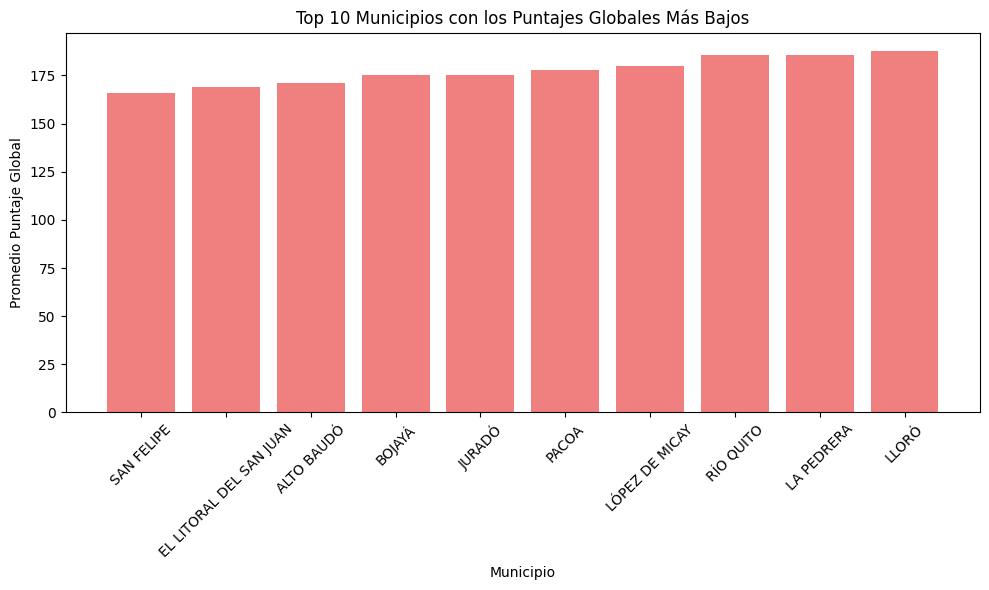

In [0]:
# Paso 1: Calcular el promedio de los puntajes globales por municipio
df_avg_by_mcpio = df_filled.groupBy("ESTU_MCPIO_RESIDE").agg(
    mean("PUNT_GLOBAL").alias("avg_PUNT_GLOBAL")
)

# Paso 2: Ordenar por el puntaje global promedio de menor a mayor y seleccionar los 10 más bajos
df_top_10_lowest_mcpio = df_avg_by_mcpio.orderBy("avg_PUNT_GLOBAL", ascending=True).limit(10)

# Convertir el resultado a un Pandas DataFrame para graficar
df_top_10_lowest_mcpio_pd = df_top_10_lowest_mcpio.toPandas()

# Paso 3: Generar la gráfica
plt.figure(figsize=(10, 6))
plt.bar(df_top_10_lowest_mcpio_pd["ESTU_MCPIO_RESIDE"], df_top_10_lowest_mcpio_pd["avg_PUNT_GLOBAL"], color='lightcoral')
plt.xlabel("Municipio")
plt.ylabel("Promedio Puntaje Global")
plt.title("Top 10 Municipios con los Puntajes Globales Más Bajos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

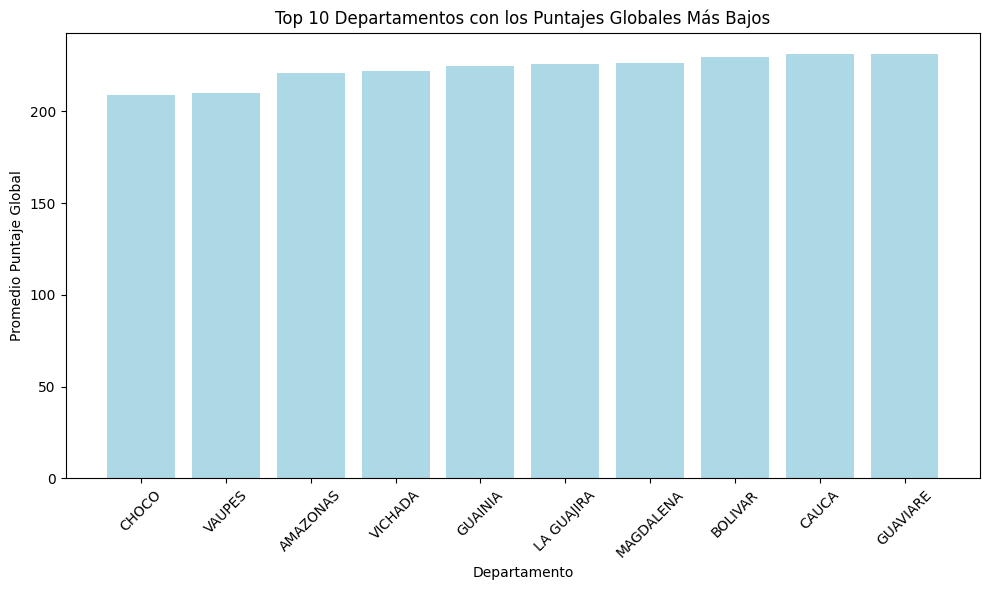

In [0]:
# Paso 1: Calcular el promedio de los puntajes globales por departamento
df_avg_by_depto = df_filled.groupBy("ESTU_DEPTO_RESIDE").agg(
    mean("PUNT_GLOBAL").alias("avg_PUNT_GLOBAL")
)

# Paso 2: Ordenar por el puntaje global promedio de menor a mayor y seleccionar los 10 más bajos
df_top_10_lowest_depto = df_avg_by_depto.orderBy("avg_PUNT_GLOBAL", ascending=True).limit(10)

# Convertir el resultado a un Pandas DataFrame para graficar
df_top_10_lowest_depto_pd = df_top_10_lowest_depto.toPandas()

# Paso 3: Generar la gráfica
plt.figure(figsize=(10, 6))
plt.bar(df_top_10_lowest_depto_pd["ESTU_DEPTO_RESIDE"], df_top_10_lowest_depto_pd["avg_PUNT_GLOBAL"], color='lightblue')
plt.xlabel("Departamento")
plt.ylabel("Promedio Puntaje Global")
plt.title("Top 10 Departamentos con los Puntajes Globales Más Bajos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


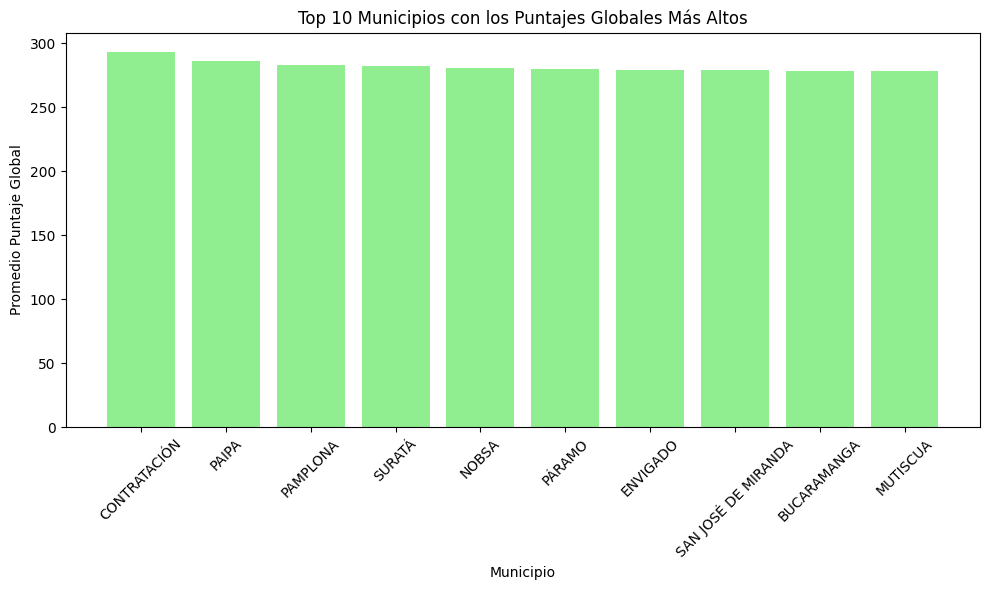

In [0]:


# Paso 1: Calcular el promedio de los puntajes globales por municipio
df_avg_by_mcpio = df_filled.groupBy("ESTU_MCPIO_RESIDE").agg(
    mean("PUNT_GLOBAL").alias("avg_PUNT_GLOBAL")
)

# Paso 2: Ordenar por el puntaje global promedio de mayor a menor y seleccionar los 10 más altos
df_top_10_highest_mcpio = df_avg_by_mcpio.orderBy("avg_PUNT_GLOBAL", ascending=False).limit(10)

# Paso 3: Obtener los resultados y preparar para graficar
result = df_top_10_highest_mcpio.collect()

# Extraer los valores para la gráfica
municipios = [row['ESTU_MCPIO_RESIDE'] for row in result]
promedios = [row['avg_PUNT_GLOBAL'] for row in result]

# Paso 4: Generar la gráfica
plt.figure(figsize=(10, 6))
plt.bar(municipios, promedios, color='lightgreen')

plt.xlabel("Municipio")
plt.ylabel("Promedio Puntaje Global")
plt.title("Top 10 Municipios con los Puntajes Globales Más Altos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


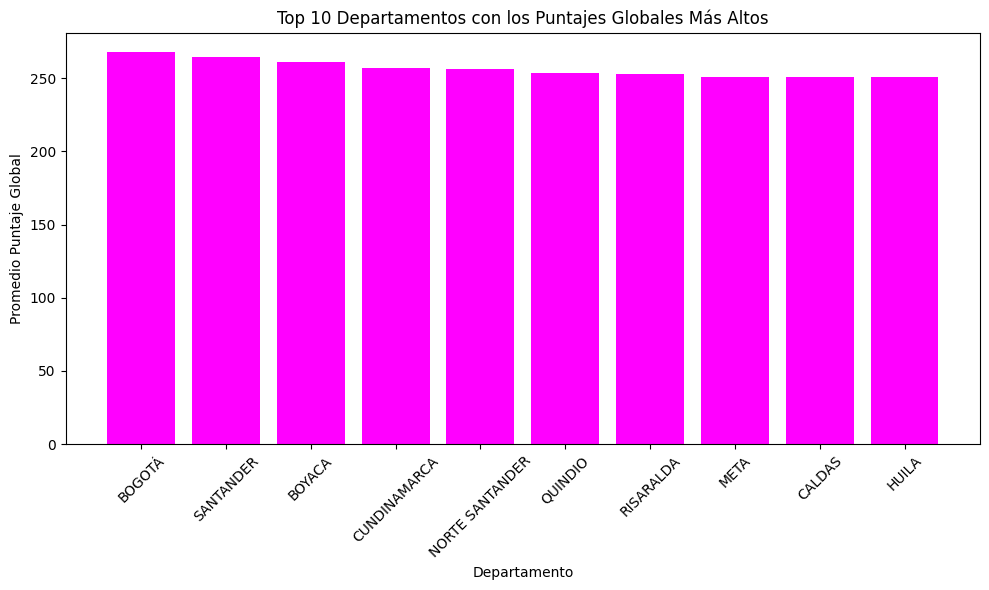

In [0]:

# Paso 1: Calcular el promedio de los puntajes globales por departamento
df_avg_by_depto = df_filled.groupBy("ESTU_DEPTO_RESIDE").agg(
    mean("PUNT_GLOBAL").alias("avg_PUNT_GLOBAL")
)

# Paso 2: Ordenar por el puntaje global promedio de mayor a menor y seleccionar los 10 más altos
df_top_10_highest_depto = df_avg_by_depto.orderBy("avg_PUNT_GLOBAL", ascending=False).limit(10)

# Paso 3: Obtener los resultados y preparar para graficar
result = df_top_10_highest_depto.collect()

# Extraer los valores para la gráfica
departamentos = [row['ESTU_DEPTO_RESIDE'] for row in result]
promedios = [row['avg_PUNT_GLOBAL'] for row in result]

# Paso 4: Generar la gráfica
plt.figure(figsize=(10, 6))
plt.bar(departamentos, promedios, color='magenta')

plt.xlabel("Departamento")
plt.ylabel("Promedio Puntaje Global")
plt.title("Top 10 Departamentos con los Puntajes Globales Más Altos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
